In [ ]:
!pip install imbalanced-learn==0.8.1

In [ ]:
!pip install yellowbrick==1.2

In [ ]:
!pip uninstall numpy
!pip install numpy==1.22.4

In [ ]:
!pip install sklearn

In [ ]:

!pip install auto-sklearn

In [ ]:
!pip install scikit-learn==1.2.2

In [ ]:
!pip install PipelineProfiler

In [ ]:
!pip install feature_engine

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import Cython
import autosklearn
import autosklearn.classification
import autosklearn.regression
import PipelineProfiler
from sklearn.metrics import mean_squared_error

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline , Pipeline
from feature_engine.outliers import Winsorizer
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from feature_engine.encoding import OneHotEncoder
from scipy.fft import fft, fftfreq
from sklearn.model_selection import train_test_split
from numpy.fft import rfft, irfft, rfftfreq
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from feature_engine.creation import CyclicalFeatures
pd.set_option('display.max_columns', None)

In [ ]:
def detect_seasonality(df, target_column):

    # Ensure the DataFrame index is a valid date/time index
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex.")

    # Decompose the time series to capture seasonality
    decomposition = sm.tsa.seasonal.seasonal_decompose(df[target_column], model='additive', extrapolate_trend='freq')

    # Test if the residuals exhibit any seasonality
    seasonal_component = decomposition.seasonal
    mean_seasonality = np.mean(seasonal_component)
    is_additive = np.allclose(seasonal_component, mean_seasonality, atol=1e-3)

    # Determine the seasonality type
    if is_additive:
        return "additive"
    else:
        return "multiplicative"

In [ ]:
def preprocess_seasonality(df,target,seasonality_type="additive"):
    if seasonality_type == "multiplicative":
        df[target] = np.log(df[target]+1)
    return df

In [ ]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cappers = {}
    def fit(self, X, y=None, capping_method="iqr", tail='both', fold=1.5):
        for col in X.select_dtypes(include='number'):
            decomposed = STL(X[col], robust=True,period=12).fit()
            residuals = decomposed.resid
            capper = Winsorizer(capping_method=capping_method, tail=tail, fold=fold)
            capper.fit(pd.DataFrame(residuals))
            self.cappers[col] = capper
        return self

    def transform(self, X):
        for col in X.select_dtypes(include='number'):
            decomposed = STL(X[col], robust=True,period=12).fit()
            residuals = decomposed.resid
            capper = self.cappers[col]
            residuals = capper.transform(pd.DataFrame(residuals))
            X[col] = residuals.resid + decomposed.trend + decomposed.seasonal
        return X

In [ ]:
class MissingValuesHandler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        numerical_cols = df.select_dtypes(include='number').columns
        for col in numerical_cols:
            # Interpolate data to decompose seasonality
            df[col] = df[col].interpolate(method="linear")
            decomposed = STL(df[col], robust=True,period=12).fit()
            y_deseasonalized = X[col] - decomposed.seasonal
            # Remove seasonality then interpolate on Trend and Residuals
            y_deseasonalized = y_deseasonalized.interpolate(method="linear")
            # Re-adding Seasonal Component
            X[col] = y_deseasonalized + decomposed.seasonal
        return X

In [ ]:
class StationarityCheckTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, target=None):
        self.target_column = target  # Rename to singular form
        self.diff = []

    def fit(self, X, y=None):
        data = X.copy()
        self.columns = data.select_dtypes(include="number").columns.tolist()

        trial = 0
        gg = data[self.target_column].values.tolist()
        cleanedList = [x for x in gg if str(x) != 'nan']
        result = adfuller(cleanedList)

        # Extract the p-value from the test result
        p_value = result[1]

        while trial < 3 and p_value >= 0.05:
            if trial == 2:
                self.diff.append(0)
                break
            data[self.target_column] = data[self.target_column].diff(1)
            gg = data[self.target_column].values.tolist()
            cleanedList = [x for x in gg if str(x) != 'nan']
            result = adfuller(cleanedList)
            p_value = result[1]
            trial += 1

        if p_value < 0.05:
            self.diff.append(trial)

        return self

    def transform(self, X):
        data = X.copy()

        diff_column = f"{self.target_column}_differ"
        data[diff_column] = data[self.target_column]

        for _ in range(self.diff[0]):
            data[diff_column] = data[diff_column].diff(1)

        return data

In [ ]:
class CyclicalFeaturesExtraction(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        datetime = pd.DataFrame(index=X.index)
        datetime["datetime"] =  pd.to_datetime(datetime.index)
        datetime["year"] = datetime["datetime"].dt.year
        datetime["month"] = datetime["datetime"].dt.month
        datetime["day"] = datetime["datetime"].dt.day
        datetime["hour"] = datetime["datetime"].dt.hour
        datetime["minute"] = datetime["datetime"].dt.minute
        datetime = datetime.drop(columns=["datetime"])
        datetime = RemoveConstantFeatures().fit_transform(datetime)
        datetime = CyclicalFeatures(variables=list(datetime.columns),drop_original=True).fit_transform(datetime)
        X = X.join(datetime)
        return X

In [ ]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = None
        self.categorical_cols = []

    def fit(self, X, y=None):
        # Identify categorical columns
        self.categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
        if self.categorical_cols:
            self.encoder = OneHotEncoder(variables=self.categorical_cols).fit(X)
        return self

    def transform(self, X):
        if self.categorical_cols:
            X = self.encoder.transform(X)
        return X

In [ ]:
class DatetimeFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X["datetime"] =  pd.to_datetime(X.index)
        X["hour"] =X["datetime"].dt.hour
        X['day'] = X["datetime"].dt.day
        X["month"] = X["datetime"].dt.month
        X = X.drop(columns="datetime")
        return X

In [ ]:
class RemoveConstantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self) :
        self.columns_to_drop=[]
    def fit(self, X, y=None):
        # Check if any column has the same value for all rows
        for column in X.columns:
            if X[column].nunique() == 1:
                self.columns_to_drop.append(column)
        return self
    def transform(self, X):
        X = X.drop(columns=self.columns_to_drop)
        return X

In [ ]:
class RollingAverageTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, window_size,target=None):
        self.window_size = window_size
        self.target = target
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        rolling_avg = X[self.target].rolling(window=self.window_size).mean()
        X['rolling_avg'] = rolling_avg.shift(1)
        return X

In [ ]:
class DropNansTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.dropna()
        return X

In [ ]:
class LagFeatureExtractor(BaseEstimator, TransformerMixin):

    def __init__(self, max_lag=30,alpha=0.05):
        self.max_lag = max_lag
        self.alpha = alpha
        self.significant_lags = []
        self.sig_fet = {}

    def fit(self, X, y=None):
        cols = [col for col in X.columns if 'differ' in col]
        for col in cols:
            self.significant_lags = []
            m = 0
            pacf_values, conf_interval = pacf(X[col], nlags=self.max_lag, method='ols', alpha=self.alpha)

            result = np.zeros((len(pacf_values), 2))
            result[:, 0] = conf_interval[:len(pacf_values), 0] - pacf_values
            result[:, 1] = conf_interval[:len(pacf_values), 1] - pacf_values

            new = result[1]
            for i in range(len(pacf_values)):
                if i == 0:
                    continue
                if pacf_values[i] < new[0] or pacf_values[i] > new[1]:
                    self.significant_lags.append(i)
                    self.sig_fet[col] = self.significant_lags

                    m = 0
                else:
                    m += 1
                    if m == 3:
                        break

        return self

    def transform(self, X, y=None):
        for key, value in self.sig_fet.items():
            for i in value:
                lag_column = X[key].shift(i)
                new_column_name = f"lag_{key}_{i}"
                X[new_column_name] = lag_column
        return X

In [ ]:
class DuplicateColumnRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.T.drop_duplicates().T
        return X

In [ ]:
timestamp = "Timestamp"
target = "Room_Temperature"
path = "/content/room_temperature.csv"

df = pd.read_csv(path,parse_dates=[timestamp] ,index_col = timestamp)
seosnailty_type = detect_seasonality(df,target)
print("Seosonality Type : " + seosnailty_type)
preprocess_seasonality(df,target,seosnailty_type)
# seosnailty_type = "additive"

Seosonality Type : multiplicative


,Room_Temperature
Timestamp,
2022-01-04 00:00:00,3.084979
2022-01-04 01:00:00,3.091042
2022-01-04 02:00:00,3.084979
2022-01-04 03:00:00,3.075005
2022-01-04 04:00:00,3.063391
...,...
2022-10-24 19:00:00,3.279670
2022-10-24 20:00:00,3.265110
2022-10-24 21:00:00,3.242592


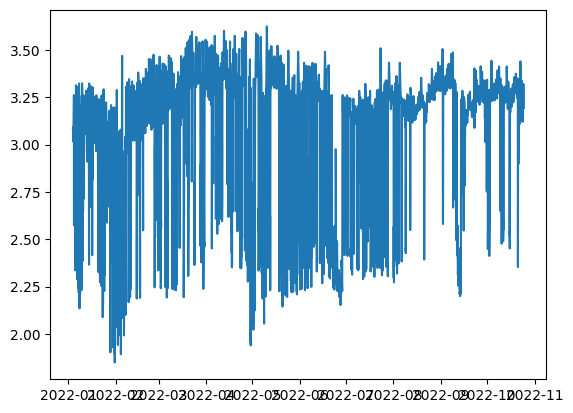

In [ ]:
plt.plot(df.index,df[target])

In [ ]:
from sklearn.pipeline import make_pipeline , Pipeline
# Data_Preprocssing_Pipeline = make_pipeline(
#     OutlierHandler(),
#     MissingValuesHandler(),
# )

Features_Pipeline = make_pipeline(
    StationarityCheckTransformer(target=target),
    CyclicalFeaturesExtraction(),
    CustomOneHotEncoder(),
    DatetimeFeatures(),
    RemoveConstantFeatures(),
    RollingAverageTransformer(window_size=3,target=target),
    DropNansTransformer(),
    LagFeatureExtractor(),
    DropNansTransformer(),
    DuplicateColumnRemover()
    )
General_Pipeline = make_pipeline(
    # Data_Preprocssing_Pipeline,
    Features_Pipeline
)

In [ ]:
train = df[:int(len(df)*0.8)]
test = df[int(len(df)*0.8):]

In [ ]:
train_df = General_Pipeline.fit_transform(train)

In [ ]:
train_df.columns

Index(['Room_Temperature', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'hour_sin', 'hour_cos', 'hour', 'day', 'month', 'rolling_avg',
       'lag_Room_Temperature_differ_1', 'lag_Room_Temperature_differ_2',
       'lag_Room_Temperature_differ_3', 'lag_Room_Temperature_differ_4',
       'lag_Room_Temperature_differ_5', 'lag_Room_Temperature_differ_7',
       'lag_Room_Temperature_differ_8', 'lag_Room_Temperature_differ_9'],
      dtype='object')

In [ ]:
test_df = General_Pipeline.transform(test)

In [ ]:
X_train = train_df.drop(columns=target)
y_train = train_df[target]

X_test = test_df.drop(columns=target)
y_test = test_df[target]

In [ ]:
X_train.shape , X_test.shape

((5632, 18), (1400, 18))

In [ ]:
# Create a pipeline with the FourierSeriesTransformer and a classifier
Auto_Sklearn_Regressor = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=60*10 ,
                                                                  per_run_time_limit=60*0.5,
                                                                  resampling_strategy = "holdout",
                                                                  resampling_strategy_arguments={"train_size": 0.9 ,"shuffle": False}
                                                                  )

# Fit the pipeline on the training data
Auto_Sklearn_Regressor.fit(X_train, y_train)

[WARNING] [2023-06-24 07:16:07,504:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-24 07:16:38,653:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-24 07:16:39,536:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-24 07:16:40,360:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-24 07:16:41,172:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-24 07:16:43,915:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-24 07:16:45,256:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-24 07:16:49,992:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-24 07:16:50,879:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-24 07:17:

AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     per_run_time_limit=30.0,
                     resampling_strategy_arguments={'shuffle': False,
                                                    'train_size': 0.9},
                     time_left_for_this_task=600)

In [ ]:
# Predict on the test data
y_predict = Auto_Sklearn_Regressor.predict(X_test)

In [ ]:
if seosnailty_type=="multiplicative":
  r2 = r2_score(np.exp(y_test), np.exp(y_predict))
else:
  r2 = r2_score(y_test,y_predict)
print(f"R2_score : {r2:.5f}" )

R2_score : 0.80907


In [ ]:
if seosnailty_type=="multiplicative":
  mse = mean_squared_error(np.exp(y_test), np.exp(y_predict))
else:
  mse = mean_squared_error(y_test,y_predict)
print(f"MSE : {mse:.5f}")

MSE : 4.33254


In [ ]:
if seosnailty_type=="multiplicative":
  rmse = mean_squared_error(np.exp(y_test), np.exp(y_predict) , squared=False)
else:
  rmse = mean_squared_error(y_test,y_predict, squared=False)
print(f"RMSE : {rmse:.5f}")

RMSE : 2.08147


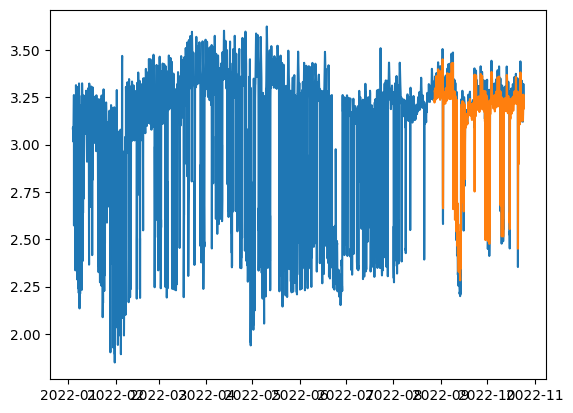

In [ ]:
plt.plot(df.index,df[target])
plt.plot(X_test.index,y_predict)
plt.show()

In [ ]:
if seosnailty_type=="multiplicative":
  data = pd.DataFrame(np.exp(df.loc[:,target]))
  predict = pd.DataFrame(index=X_test.index)
  predict["prediction"] = np.exp(y_predict)
else:
  data = pd.DataFrame(df.loc[:,target])
  predict = pd.DataFrame(index=X_test.index)
  predict["prediction"] = y_predict

In [ ]:
predict.to_csv(f"{path} Autosklearn predictions.csv")